In [18]:
from functools import partial
import jax
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

import tensorflow_datasets as tfds

import torch

from dataclasses import dataclass

from typing import Union

import matplotlib.pyplot as plt
import seaborn

# from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers
from tqdm import tqdm

import pdb

In [19]:
with open('/kaggle/input/shak-new-input/train.txt', 'r', encoding='utf-8') as f:
    text_train = f.read()
    
with open('/kaggle/input/shak-new-input/test.txt', 'r', encoding='utf-8') as f:
    text_validation = f.read()    

In [20]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text_train+text_validation)))
# chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [21]:
# create a mapping from characters to integers
stoi = { ch: i for i,ch in enumerate(chars) }
itos = { i: ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [22]:
train_data = jnp.array(encode(text_train), dtype=jnp.int32)
test_data = jnp.array(encode(text_validation), dtype=jnp.int32)
block_size = 8
train_data[:block_size+1]

Array([18, 47, 56, 57, 58,  1, 15, 47, 58], dtype=int32)

In [23]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [24]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
seq_size = block_size//8

num_layers = 5

max_iters = 50000
learning_rate = 5e-3
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
mamba_n_embd = 256
expans = 2
emb_features = mamba_n_embd * expans
s6_n_embd = 64
# hidden_dim = s6_n_embd*expans*4
conv_k_size = 3
n_latent_dim = 16
n_tokens = 1

rng_key = jax.random.PRNGKey(1564)

dynamic_slice_vmap = jax.vmap(jax.lax.dynamic_slice, in_axes=(None, 0, None))

@jax.jit
def get_batch(random_key, data):
    """Prepares a random batch of training data.

    Args:
      random_key: A random seed for sampling a batch.
      data: The complete training dataset.

    Returns:
      x: Input sequences.
      y: Target sequences (shifted inputs).
    """
    ix = jax.random.randint(
      random_key, shape=(batch_size, 1), minval=0, maxval=len(data) - block_size
    )
    x = dynamic_slice_vmap(data, ix, (block_size,))
    y = dynamic_slice_vmap(data, ix + block_size, (1,))
    return x, y

xb, yb = get_batch(rng_key, train_data)
train_shape = xb.shape
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
(64, 128)
[[58 46 43 ... 39 52 11]
 [50  1 53 ... 53 44  1]
 [58 46 39 ...  6  1 52]
 ...
 [53  1 51 ...  1 57 46]
 [11  1 39 ... 57 43 42]
 [ 0  0 25 ... 60 43 56]]
targets:
(64, 1)
[[ 1]
 [24]
 [53]
 [ 5]
 [43]
 [ 1]
 [52]
 [59]
 [43]
 [43]
 [ 1]
 [31]
 [39]
 [53]
 [ 1]
 [40]
 [16]
 [43]
 [ 1]
 [47]
 [40]
 [43]
 [43]
 [58]
 [63]
 [ 1]
 [40]
 [41]
 [ 1]
 [32]
 [32]
 [32]
 [39]
 [43]
 [57]
 [52]
 [13]
 [63]
 [ 1]
 [39]
 [42]
 [ 1]
 [40]
 [43]
 [35]
 [52]
 [42]
 [39]
 [58]
 [56]
 [31]
 [57]
 [44]
 [ 1]
 [52]
 [58]
 [57]
 [58]
 [52]
 [ 1]
 [39]
 [39]
 [ 6]
 [ 1]]


In [25]:
print(xb[0])
print(yb[0])

[58 46 43 56  6  0 35 46 53  1 46 39 57  1 39  1 41 46 39 56 58 43 56  1
 58 53  1 43 62 58 53 50  1 46 43 56  1 40 50 53 53 42  6  0 35 46 43 52
  1 57 46 43  1 42 53 43 57  1 54 56 39 47 57 43  1 51 43  1 45 56 47 43
 60 43 57  1 51 43  8  1 21  1 46 39 60 43  1 42 53 52 43  0 13 57  1 63
 53 59  1 46 39 60 43  1 42 53 52 43 11  1 58 46 39 58  5 57  1 61 46 39
 58  1 21  1 41 39 52 11]
[1]


In [26]:
# sdffsdfsdf

In [27]:
# class Mamba(nn.Module):

#     def setup(self):
#         self.in_proj1 = nn.Dense(features=emb_features)
#         self.in_proj2 = nn.Dense(features=emb_features)

#         # Adjusted for Flax. Flax does not have nn.Conv1d, so you might need to reshape or use a different approach
#         self.conv1d = nn.Conv(features=emb_features,
#                               kernel_size=conv_k_size,
#                               padding=1,
#                               )

#         self.A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, emb_features, 1))
#         self.B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, block_size))
#         self.C = 0.09*self.param('C', jax.random.normal, (1, n_latent_dim, 1, block_size))
#         self.D = 0.1*self.param('D', jax.random.normal, (1, 1,emb_features, block_size))
#         self.delta = 0.05*self.param('delta', jax.random.normal, (1, 1,emb_features, block_size))

#         self.out_proj = nn.Dense(mamba_n_embd)
        
# #         self.rms_norm = nn.RMSNorm()

#     def __call__(self, embeds):
#         x = self.in_proj1(embeds)
#         x = jax.nn.silu(x) 
#         x = self.conv1d(x)
#         x = jax.nn.silu(x)
# #         pdb.set_trace()

#         x = jnp.expand_dims(jnp.transpose(x,(0,2,1)), axis=1)
#         x = self.ssm(x)
#         x = jnp.transpose(x[:,0,:,:],(0,2,1))
#         x = x*jax.nn.silu(self.in_proj2(embeds))

#         x = self.out_proj(x)

# #         x = self.rms_norm(x)

#         return x
#     def discretize(self):
#         da = self.delta * self.A
#         a_ = jnp.exp(da)
#         b_ = self.B * self.delta
#         return a_, b_

#     def ssm(self, x):
#         a_, b_ = self.discretize()
#         h = 0
#         for k in range(x.shape[-1]):
#             h = a_[..., k] * h + b_[..., k] * x[..., k]
# #         _, N, D, S = a_.shape
# #         indices = jnp.tril(jnp.ones((S-1,S-1))) 
# #         indices = jnp.expand_dims(a_[...,1:],axis=4)*jnp.expand_dims(indices, axis=(0,1,2)) + jnp.expand_dims(jnp.triu(jnp.ones((S-1,S-1)),1), axis=(0,1,2))
# #         indices = (jnp.concatenate((indices, jnp.ones((1,N,D,S-1,1))), axis=-1)).prod(axis=-2)
# #         h = (indices*(b_*x)).sum(axis=-1)

#         y = ((self.C * jax.lax.expand_dims(h,[3])).sum(1, keepdims=True) + self.D*x)
        
# #         self.hidden_state.value = jax.nn.standardize(h.mean(0, keepdims=True))
#         return y

In [28]:
class Down_Conv(nn.Module):
    features: int = 256
    kernel_size: int = 2
    padding: int = 1
    
    @nn.compact
    def __call__(self, x):
        
        conv1 = jax.nn.silu(nn.Conv(features=self.features, kernel_size=self.kernel_size,padding=self.padding)(x))
        max_pool1 = nn.max_pool(conv1 , window_shape=(self.kernel_size,), strides=(2,), padding='same')
#         max_pool1_ind = (conv1 == jnp.repeat(max_pool1 , repeats=2, axis=1)).astype(jnp.int32)
        #########################################################################################################
        conv2 = jax.nn.silu(nn.Conv(features=self.features*2, kernel_size=self.kernel_size,padding=self.padding)(max_pool1))
        max_pool2 = nn.max_pool(conv2 , window_shape=(self.kernel_size,), strides=(2,), padding='same')
#         max_pool2_ind = (conv2 == jnp.repeat(max_pool2 , repeats=2, axis=1)).astype(jnp.int32)   
        #########################################################################################################
        conv3 = jax.nn.silu(nn.Conv(features=self.features*4, kernel_size=self.kernel_size,padding=self.padding)(max_pool2))
        max_pool3 = nn.max_pool(conv3 , window_shape=(self.kernel_size,), strides=(2,), padding='same')
#         max_pool3_ind = (conv3 == jnp.repeat(max_pool3 , repeats=2, axis=1)).astype(jnp.int32)
        ######################################################################################################### 
        
        return nn.RMSNorm()(max_pool3)

In [29]:
class S6_Unet(nn.Module):
    
    @nn.compact
    def __call__(self, x, h=0):
        # x.shape = (Ba, 1, seq_size, hidden_dim)
        hidden_dim = x.shape[-1]
        
        A = -1*self.param('A', nn.initializers.ones, (1, n_latent_dim, hidden_dim, 1))
        B = 0.1*self.param('B', nn.initializers.ones, (1, n_latent_dim, 1, seq_size))
        C = 0.09*self.param('C', jax.random.normal, (1, n_latent_dim, hidden_dim))
        D = 0.1*self.param('D', jax.random.normal, (1, 1, hidden_dim))
        delta = 0.05*self.param('delta', jax.random.normal, (1, 1, hidden_dim, seq_size))
        
        x = jnp.expand_dims(jnp.transpose(x,(0,2,1)), axis=1)
        # x.shape = (Ba, 1, hidden_dim, seq_size)
        x, h = self.ssm(x, A, B, C, D, delta, h)
#         pdb.set_trace()
#         x = jnp.transpose(x[:,0,:,:],(0,2,1))
        #########################################################################################################
#         uconv3 = jnp.repeat(x, repeats=2, axis=1)*jnp.concatenate([max_pool3_ind[:,1:,:],jnp.ones((max_pool3_ind.shape[0],1,max_pool3_ind.shape[-1]))], axis=1)
#         cat_conv3 = jnp.concatenate([conv3, uconv3], axis=-1)
#         conv4 = jax.nn.silu(nn.Conv(features=cat_conv3.shape[-1]//2, kernel_size=conv_k_size,padding=1)(cat_conv3))
#         conv3T = nn.ConvTranspose(x.shape[-1]//2, kernel_size = 3, padding = 1)(x)
        #########################################################################################################
#         uconv2 = jnp.repeat(conv3T, repeats=2, axis=1)*jnp.concatenate([max_pool2_ind[:,1:,:],jnp.ones((max_pool2_ind.shape[0],1,max_pool2_ind.shape[-1]))], axis=1)
#         cat_conv2 = jnp.concatenate([conv2, uconv2], axis=-1)
#         conv5 = jax.nn.silu(nn.Conv(features=cat_conv2.shape[-1]//2, kernel_size=conv_k_size,padding=1)(cat_conv2))
#         conv2T = nn.ConvTranspose(conv3T.shape[-1]//2, kernel_size = 3, padding = 1)(conv3T)
        #########################################################################################################
#         uconv1 = jnp.repeat(conv2T, repeats=2, axis=1)*jnp.concatenate([max_pool1_ind[:,1:,:],jnp.ones((max_pool1_ind.shape[0],1,max_pool1_ind.shape[-1]))], axis=1)
#         cat_conv1 = jnp.concatenate([conv1, uconv1], axis=-1)
#         conv6 = jax.nn.silu(nn.Conv(features=cat_conv1.shape[-1]//2, kernel_size=conv_k_size,padding=1)(cat_conv1))
#         conv1T = nn.ConvTranspose(conv2T.shape[-1]//2, kernel_size = 3, padding = 1)(conv2T)
        #########################################################################################################
        return x, h
    
    def discretize(self, A, B, delta):
        da = delta * A
        a_ = jnp.exp(da)
        b_ = B * delta
        return a_, b_
 
    def ssm(self, x, A, B, C, D, delta, h=0):
        a_, b_ = self.discretize(A, B, delta)
        for k in range(x.shape[-1]):
            h = a_[..., k] * h + b_[..., k] * x[..., k]
#         _, N, D, S = a_.shape
#         indices = jnp.tril(jnp.ones((S-1,S-1))) 
#         indices = jnp.expand_dims(a_[...,1:],axis=4)*jnp.expand_dims(indices, axis=(0,1,2)) + jnp.expand_dims(jnp.triu(jnp.ones((S-1,S-1)),1), axis=(0,1,2))
#         indices = (jnp.concatenate((indices, jnp.ones((1,N,D,S-1,1))), axis=-1)).prod(axis=-2)
#         h = (indices*(b_*x)).sum(axis=-1)
        y = ((C * h).sum(1, keepdims=True)) + D*x[:,:,:,-1]

#         self.hidden_state.value = jax.nn.standardize(h.mean(0, keepdims=True))
        return y, h

In [30]:
class FeedForward(nn.Module):

    @nn.compact
    def __call__(self, x):
        hidden_dim = x.shape[-1]
        x = jax.nn.silu(nn.Dense(hidden_dim//2)(x))
        x = jax.nn.silu(nn.Dense(hidden_dim//4)(x))
        x = jax.nn.silu(nn.Dense(hidden_dim//8)(x))
        x = jax.nn.silu(nn.Dense(hidden_dim//4)(x))
        x = jax.nn.silu(nn.Dense(hidden_dim//2)(x))
        x = jax.nn.silu(nn.Dense(hidden_dim)(x))
        return x

In [31]:
class LLM_Model(nn.Module):
    
    @nn.compact
    def __call__(self, x, h=0):
        embeds = nn.Embed(vocab_size, mamba_n_embd)(x) + nn.Embed(block_size, mamba_n_embd)(jnp.arange(block_size))
    
#         for _ in range(num_layers):
#             x = x + Mamba()(nn.RMSNorm()(x))

        x0 = Down_Conv(features=s6_n_embd, kernel_size=2, padding=1)(embeds)
        x0, h0 = S6_Unet()(nn.RMSNorm()(x0), h)
    
        x1 = Down_Conv(features=s6_n_embd, kernel_size=4, padding=2)(embeds)
        x1, h1 = S6_Unet()(nn.RMSNorm()(x1), h)
        
        x2 = Down_Conv(features=s6_n_embd, kernel_size=8, padding=4)(embeds)
        x2, h2 = S6_Unet()(nn.RMSNorm()(x2), h)
        
        x3 = Down_Conv(features=s6_n_embd, kernel_size=16, padding=8)(embeds)
        x3, h3 = S6_Unet()(nn.RMSNorm()(x3), h)
        
        

        x = x0 + x1 + x2 + x3
#         x = x + Mamba()(nn.RMSNorm()(x))
    
         # * jnp.concatenate([x[:,1:,:],jnp.ones((x.shape[0],1,x.shape[-1]))], axis=1)
        
        x = x + FeedForward()(nn.RMSNorm()(x))
        
        x = nn.Dense(mamba_n_embd)(nn.RMSNorm()(x))
        
        x = nn.Dense(vocab_size)(nn.RMSNorm()(x))
        
        return x, h3

In [32]:
def loss_fun(params, x, y, dropout_key):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

@jax.jit
def eval_step(params, x, y):
    logits, _ = model.apply(params, x)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == y)
    return optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=y).mean(), accuracy

In [33]:
key = jax.random.PRNGKey(42)
# x = jnp.expand_dims(xb[0],axis=0)
x = xb

model = LLM_Model()

params = model.init(jax.random.PRNGKey(45),x)
print(params.keys())
n_params = sum(p.size for p in jax.tree_util.tree_leaves(params))

print(f"Total number of parameters: {n_params:_}")

output, h = model.apply(params, x)
print(output.shape, h.shape)

dict_keys(['params'])
Total number of parameters: 1_994_721
(64, 1, 65) (64, 16, 256)


In [34]:
# sdfgdfgdg

In [35]:
# lr_schedule  = optax.linear_schedule(init_value=learning_rate,end_value=learning_rate/10,transition_steps=eval_iters)

opt = optax.adamw(learning_rate=learning_rate)

opt_state = opt.init(params)

In [36]:
%%time

all_train_losses = []
all_eval_losses = []

all_train_accuracy =  []
all_test_accuracy = []

# we define one iteration of the optimizer and JIT this function
@jax.jit
def step(key, params, opt_state):
    key, subkey = jax.random.split(key)
    xb, yb = get_batch(key, train_data)
    (loss, train_accuracy), grad = jax.value_and_grad(loss_fun, has_aux=True)(params, xb, yb, subkey)
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, key, opt_state, loss, train_accuracy

# for i in tqdm(range(max_iters)):
counter = 0
loss = 10
while counter<max_iters: # and loss > 1.0:

    params, key, opt_state, loss, train_accuracy = step(key, params, opt_state)
    

    # once every N_FREQ_EVAL we compute loss on the validation set
    if counter % eval_iters == 0:
        key, subkey = jax.random.split(key)
        eval_loss, eval_accuracy = eval_step(params, *get_batch(subkey, test_data))
        all_train_losses.append(loss)
        all_eval_losses.append(eval_loss)
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(eval_accuracy)
        print('##########################################################')
        print("Step: ", counter,"\t Train Loss: ", loss,"\t Train Accuracy: ", format(train_accuracy, ".2%"))
        print("Step: ", counter,"\t Eval Loss: ", eval_loss,"\t\t Eval Accuracy: ", format(eval_accuracy, ".2%"))
        
    counter += 1
        

##########################################################
Step:  0 	 Train Loss:  4.843055 	 Train Accuracy:  1.56%
Step:  0 	 Eval Loss:  4.248369 		 Eval Accuracy:  0.00%
##########################################################
Step:  100 	 Train Loss:  2.971829 	 Train Accuracy:  18.75%
Step:  100 	 Eval Loss:  2.914699 		 Eval Accuracy:  21.88%
##########################################################
Step:  200 	 Train Loss:  2.5545201 	 Train Accuracy:  29.69%
Step:  200 	 Eval Loss:  2.630072 		 Eval Accuracy:  18.75%
##########################################################
Step:  300 	 Train Loss:  2.727264 	 Train Accuracy:  23.44%
Step:  300 	 Eval Loss:  2.4203398 		 Eval Accuracy:  23.44%
##########################################################
Step:  400 	 Train Loss:  2.6423411 	 Train Accuracy:  29.69%
Step:  400 	 Eval Loss:  2.230854 		 Eval Accuracy:  34.38%
##########################################################
Step:  500 	 Train Loss:  2.1492333 	 Train 

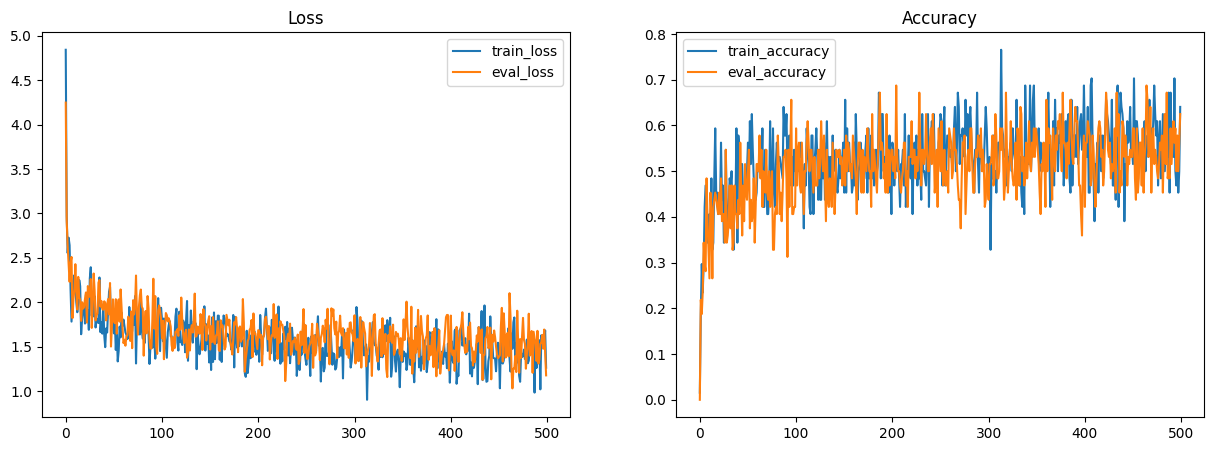

<Figure size 640x480 with 0 Axes>

In [37]:
# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')



ax1.plot(all_train_losses, label='train_loss')
ax1.plot(all_eval_losses, label='eval_loss')

ax2.plot(all_train_accuracy, label='train_accuracy')
ax2.plot(all_test_accuracy, label='eval_accuracy')

ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [38]:
@partial(jax.jit, static_argnames=("length"))
def generate_text(rng, params, length):
    def _scan_generate(carry, _):
        random_key, context = carry
        logits, _ = model.apply(params, context)
#         pdb.set_trace()
        rng, rng_subkey = jax.random.split(random_key)
        new_token = jax.random.categorical(
          rng_subkey, logits, axis=-1, shape=(1, 1)
        )
        context = jnp.concatenate([context[:, 1:], new_token], axis=1)
        print(context.shape)
        return (rng, context), new_token

    _, new_tokens = jax.lax.scan(
    _scan_generate,
    (rng, jnp.expand_dims(test_data[852:852+block_size], axis=0)),
    (),
    length=length,
    )
    return new_tokens

In [39]:
test_data[852:852+block_size]

Array([51,  6,  1, 53, 56,  1, 43, 50, 57, 43,  1, 63, 53, 59,  1, 42, 53,
        1, 51, 43,  1, 61, 56, 53, 52, 45, 10,  0, 20, 47, 57,  1, 52, 39,
       51, 43,  1, 47, 57,  1, 24, 47, 41, 47, 53,  6,  1, 40, 53, 56, 52,
        1, 47, 52,  1, 25, 39, 52, 58, 59, 39,  8,  0,  0, 14, 13, 28, 32,
       21, 31, 32, 13, 10,  0, 37, 53, 59,  5, 56, 43,  1, 61, 43, 50, 41,
       53, 51, 43,  6,  1, 57, 47, 56, 11,  1, 39, 52, 42,  1, 46, 43,  6,
        1, 44, 53, 56,  1, 63, 53, 59, 56,  1, 45, 53, 53, 42,  1, 57, 39,
       49, 43,  8,  0, 14, 59, 58,  1, 44], dtype=int32)

In [40]:
i = 852
decode(test_data[i:i+block_size].tolist())

"m, or else you do me wrong:\nHis name is Licio, born in Mantua.\n\nBAPTISTA:\nYou're welcome, sir; and he, for your good sake.\nBut f"

In [41]:
new_tokenz = 1000
key, subkey = jax.random.split(jax.random.PRNGKey(156))
# key, subkey = jax.random.split(key)
# token_gen = generate_text(jnp.zeros((1,block_size)).astype(jnp.int32), new_tokenz, {'params': state.params})
token_gen = generate_text(key, params, new_tokenz)[:, 0, 0].tolist()
print(token_gen)
print('\n')
print(decode(token_gen))

(1, 128)
[56, 53, 51, 1, 51, 63, 1, 42, 43, 39, 58, 46, 1, 52, 53, 52, 43, 1, 51, 39, 63, 1, 60, 47, 41, 43, 1, 44, 39, 47, 56, 57, 0, 14, 59, 58, 1, 58, 46, 39, 58, 1, 21, 1, 57, 39, 61, 1, 46, 43, 1, 60, 43, 56, 63, 1, 44, 56, 53, 51, 1, 58, 46, 47, 52, 45, 57, 1, 39, 56, 43, 1, 53, 52, 6, 0, 16, 53, 57, 58, 1, 58, 46, 43, 1, 44, 56, 47, 43, 52, 42, 57, 1, 59, 57, 1, 58, 56, 59, 43, 6, 1, 58, 53, 1, 46, 39, 60, 43, 1, 57, 46, 43, 1, 41, 53, 59, 50, 42, 7, 7, 0, 35, 46, 39, 58, 1, 59, 54, 1, 63, 53, 59, 1, 44, 53, 56, 1, 58, 46, 43, 1, 49, 47, 52, 45, 5, 42, 8, 1, 31, 54, 47, 56, 47, 52, 45, 12, 0, 21, 44, 1, 42, 39, 63, 1, 51, 63, 1, 39, 54, 47, 50, 43, 1, 46, 39, 42, 1, 39, 57, 1, 51, 63, 1, 42, 47, 52, 41, 53, 52, 57, 43, 58, 1, 46, 43, 56, 0, 13, 52, 42, 1, 40, 43, 1, 58, 46, 43, 1, 45, 43, 52, 58, 50, 47, 52, 45, 1, 53, 59, 56, 1, 41, 53, 58, 50, 43, 56, 1, 56, 43, 41, 47, 53, 59, 57, 0, 21, 57, 1, 58, 53, 1, 46, 47, 57, 1, 54, 39, 57, 58, 1, 40, 46, 47, 52, 43, 6, 1, 51, 63, 1, 

In [42]:
params['params'].keys()

dict_keys(['Dense_0', 'Dense_1', 'Down_Conv_0', 'Down_Conv_1', 'Down_Conv_2', 'Down_Conv_3', 'Embed_0', 'Embed_1', 'FeedForward_0', 'RMSNorm_0', 'RMSNorm_1', 'RMSNorm_2', 'RMSNorm_3', 'RMSNorm_4', 'RMSNorm_5', 'RMSNorm_6', 'S6_Unet_0', 'S6_Unet_1', 'S6_Unet_2', 'S6_Unet_3'])

In [43]:
var_params = {'params':{}}

In [44]:
var_params['params']['Conv_0'] = params['params']['S6_Unet_0']['Conv_0']

KeyError: 'Conv_0'

In [ ]:
for key in params['params']['S6_Unet_0'].keys():
    
    n_params = sum(p.size for p in jax.tree_util.tree_leaves(params['params']['S6_Unet_0'][key]))

    print(f"Total number of parameters in {key}: {n_params:_}")

In [ ]:
sum(p.size for p in jax.tree_util.tree_leaves(params['params'])) - sum(p.size for p in jax.tree_util.tree_leaves(params['params']['S6_Unet_0']))

In [ ]:
params['params']['S6_Unet_0']['Conv_2']['kernel'].shape

In [ ]:
optax.softmax_cross_entropy_with_integer_labels(logits=jnp.array([[0.0,0.0,100.0,0.0,0.0]]), labels=jnp.array([3])).mean()

In [ ]:
inputs = jax.random.normal(jax.random.PRNGKey(567), (1,8,4))
inputs

In [ ]:
class Connv1d(nn.Module):
    
    @nn.compact
    def __call__(self, x):
        
        return nn.max_pool(x , window_shape=(4,), strides=(2,), padding='same')

In [ ]:
conv_model = Connv1d()

params = conv_model.init(jax.random.PRNGKey(415),inputs)

conv_model.apply(params, inputs)

In [ ]:
conv_model.apply(params, conv_model.apply(params, inputs))